# Проект: Анализ и моделирование цен на подержанные автомобили

## 1. Краткое описание проекта
- **1.1. ФИО: Спицина Ксения Сергеевна**
- **1.2. Группа:** *Д-Э 37-25*
- **1.3. Тема проекта:** "Прогнозирование стоимости и анализ характеристик подержанных автомобилей"
- **1.4. Цель проекта:** построить предиктивные и классификационные модели, позволяющие оценивать стоимость и характеристики автомобилей на вторичном рынке, а также выявить ключевые закономерности в данных.
- **1.5. Задачи проекта:**
  1. Выполнить предобработку данных и унификацию признаков.
  2. Провести разведочный анализ данных, визуализацию и корреляционный анализ.
  3. Построить регрессионные модели (простая и множественная линейная регрессия).
  4. Построить классификационные модели (дерево решений и KNN).
  5. Провести кластерный анализ (K-Means).
  6. Реализовать нейросетевую модель для прогноза цены.
- **1.6. Аннотация:** В работе используется датасет объявлений о продаже подержанных автомобилей в Индии. После очистки данных исследуются распределения признаков, выявляются корреляции, строятся регрессионные, классификационные и кластеризационные модели. Дополнительно реализована нейронная сеть для прогноза стоимости автомобиля.

---


In [60]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor

sns.set_theme(style="whitegrid", palette="muted")
pd.options.display.float_format = "{:.2f}".format

DATA_PATH = Path("/Users/ksenia/Downloads/Used_Car_Price_Prediction.csv")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"Dataset exists: {DATA_PATH.exists()} | Size: {DATA_PATH.stat().st_size / 1e6:.2f} MB")


Dataset exists: True | Size: 1.66 MB


## 2. Загрузка и первичный осмотр данных


In [61]:
raw_df = pd.read_csv(DATA_PATH)
print(raw_df.shape)
raw_df.head()


(7400, 29)


,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,2,397677,404177.00,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,1,272935,354313.00,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,1,294262,374326.00,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,1,360716,367216.00,great,2021-04-01T13:33:40.733,True,8397,54225,False,False


In [62]:
missing_summary = raw_df.isna().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]


original_price         3280
car_availability        620
transmission            556
source                  126
body_type               103
registered_city          10
registered_state         10
car_rating                9
fitness_certificate       8
ad_created_on             1
dtype: int64

## 3. Предобработка данных

Этапы:
1. Приведение типов (даты, логические поля).
2. Заполнение пропусков/категориальных значений (моды/значения-заглушки).
3. Удаление выбросов по стоимости и пробегу.
4. Инженерия признаков (возраст авто, пробег в год, просмотры в год, частотные кодировки).
5. Удаление дубликатов.

Результат сохраняем в `clean_df` для дальнейшего анализа.


In [63]:
def frequency_encode(series: pd.Series) -> pd.Series:
    counts = series.value_counts(normalize=True)
    return series.map(counts)


def preprocess_used_cars(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()

    # 1) Приведение типов и заполнение пропусков
    fill_values = {
        "body_type": "Unknown",
        "transmission": "Unknown",
        "registered_city": "Unknown",
        "registered_state": "Unknown",
        "source": "Unknown",
        "car_availability": "Unknown",
        "car_rating": "Unknown",
        "fitness_certificate": "Unknown",
        "variant": "Unknown",
    }
    for column, value in fill_values.items():
        if column in data.columns:
            data[column] = data[column].fillna(value)

    bool_columns = ["assured_buy", "is_hot", "reserved", "warranty_avail"]
    for column in bool_columns:
        if column in data.columns:
            data[column] = data[column].astype(int)

    # Заполнение original_price медианой по марке
    if "original_price" in data.columns:
        median_by_make = data.groupby("make")["original_price"].transform("median")
        data["original_price"] = data["original_price"].fillna(median_by_make)
        data["original_price"] = data["original_price"].fillna(data["original_price"].median())

    # Дата объявления
    if "ad_created_on" in data.columns:
        data["ad_created_on"] = pd.to_datetime(data["ad_created_on"], errors="coerce")
        median_date = data["ad_created_on"].median()
        data["ad_created_on"] = data["ad_created_on"].fillna(median_date)
        data["listing_year"] = data["ad_created_on"].dt.year
        data["listing_month"] = data["ad_created_on"].dt.month
        data["listing_dayofweek"] = data["ad_created_on"].dt.dayofweek
    else:
        today = datetime.today()
        data["listing_year"] = today.year
        data["listing_month"] = today.month
        data["listing_dayofweek"] = today.weekday()

    # 2) Удаление выбросов по цене и пробегу
    price_mask = data["sale_price"].between(
        data["sale_price"].quantile(0.01), data["sale_price"].quantile(0.99)
    )
    kms_mask = data["kms_run"].between(
        data["kms_run"].quantile(0.01), data["kms_run"].quantile(0.99)
    )
    data = data[price_mask & kms_mask].copy()

    # 3) Инженерия признаков
    current_year = data["listing_year"].median()
    data["car_age"] = (current_year - data["yr_mfr"]).clip(lower=0)
    data["kms_per_year"] = data["kms_run"] / np.where(data["car_age"] == 0, 1, data["car_age"])
    data["views_per_year"] = data["times_viewed"] / np.where(data["car_age"] == 0, 1, data["car_age"])
    data["owner_multiple"] = (data["total_owners"] > 1).astype(int)

    for column in ("city", "make", "model", "fuel_type", "body_type", "transmission"):
        if column in data.columns:
            data[f"{column}_freq"] = frequency_encode(data[column]).fillna(0.0)

    if "fuel_type" in data.columns and "transmission" in data.columns:
        data["fuel_trans_combo"] = data["fuel_type"] + "_" + data["transmission"]
        data["fuel_trans_freq"] = frequency_encode(data["fuel_trans_combo"]).fillna(0.0)

    if {"car_age", "body_type"}.issubset(data.columns):
        body_freq = frequency_encode(data["body_type"]).fillna(0.0)
        data["age_body_interaction"] = data["car_age"] * body_freq

    # 4) Удаление дубликатов
    before = len(data)
    data = data.drop_duplicates()
    print(f"Удалено дубликатов: {before - len(data)}")

    return data


clean_df = preprocess_used_cars(raw_df)
clean_df.head()


Удалено дубликатов: 1


,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,owner_multiple,city_freq,make_freq,model_freq,fuel_type_freq,body_type_freq,transmission_freq,fuel_trans_combo,fuel_trans_freq,age_body_interaction
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,1,0.04,0.44,0.07,0.64,0.60,0.85,petrol_manual,0.54,3.58
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,0,0.04,0.44,0.03,0.64,0.60,0.85,petrol_manual,0.54,2.98
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,0,0.04,0.25,0.04,0.64,0.60,0.85,petrol_manual,0.54,2.39
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,0,0.04,0.44,0.07,0.30,0.60,0.85,diesel_manual,0.25,4.77
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,0,0.04,0.25,0.04,0.64,0.60,0.85,petrol_manual,0.54,3.58


In [64]:
print(clean_df.shape)
clean_df.describe(include="all").transpose().head(15)


(7116, 45)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
car_name,7116,171,maruti swift,529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yr_mfr,7116.00,NaN,NaN,NaN,2013.90,2003.00,2012.00,2014.00,2016.00,2021.00,2.95
fuel_type,7116,5,petrol,4521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kms_run,7116.00,NaN,NaN,NaN,61108.90,3587.00,32402.25,55531.00,83423.00,197377.00,37092.77
sale_price,7116.00,NaN,NaN,NaN,441668.71,90000.00,282499.00,380749.00,534524.00,1576608.00,233814.62
city,7116,13,mumbai,1284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
times_viewed,7116.00,NaN,NaN,NaN,1540.23,3.00,559.50,1087.00,1905.50,61930.00,2073.36
body_type,7116,6,hatchback,4246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,7116,3,manual,6018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variant,7116,873,vxi,663,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Визуализация данных
Построим базовые графики распределения стоимости, пробега, категориальных признаков и дополнительные сюжетные визуализации (цена vs возраст, распределение по кластерам и городам).


/var/folders/qn/80cwj5zd1j3497529nnf_3vr0000gn/T/ipykernel_85001/3317112014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


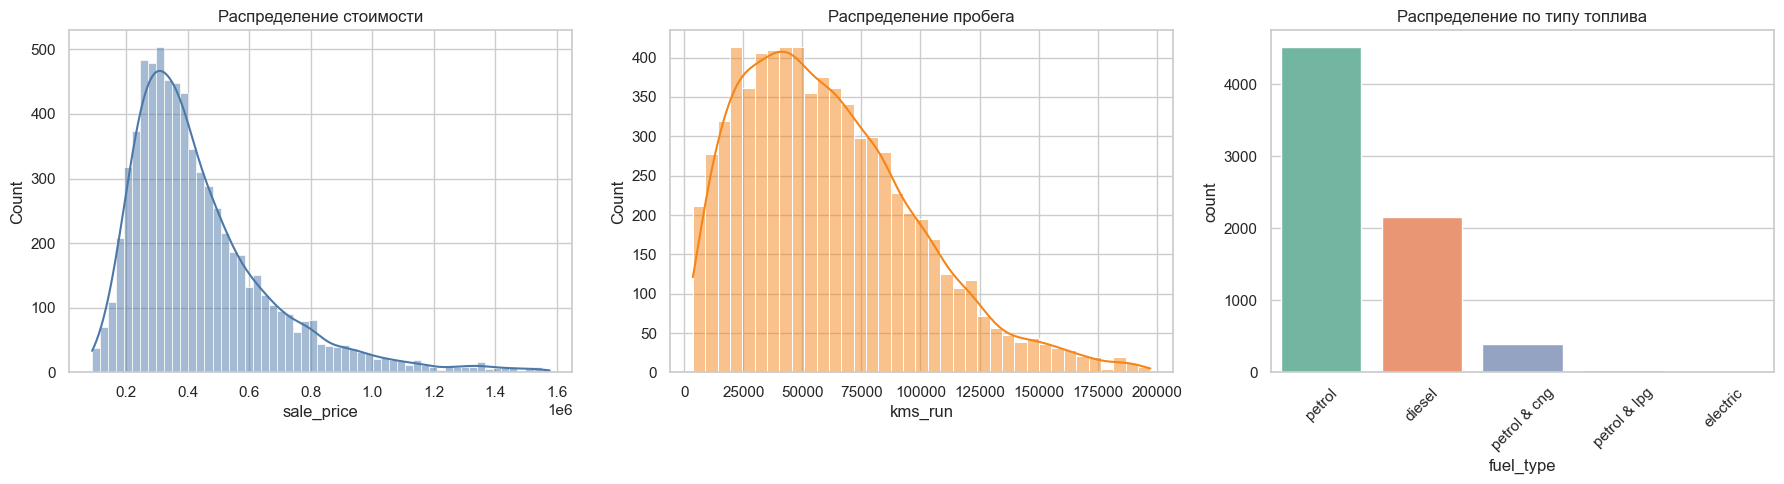

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(clean_df["sale_price"], kde=True, ax=axes[0], color="#4C78A8")
axes[0].set_title("Распределение стоимости")
axes[0].set_xlabel("sale_price")

sns.histplot(clean_df["kms_run"], kde=True, ax=axes[1], color="#F58518")
axes[1].set_title("Распределение пробега")
axes[1].set_xlabel("kms_run")

sns.countplot(
    data=clean_df.sort_values("fuel_type"),
    x="fuel_type",
    order=clean_df["fuel_type"].value_counts().index,
    ax=axes[2],
    palette="Set2",
)
axes[2].set_title("Распределение по типу топлива")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


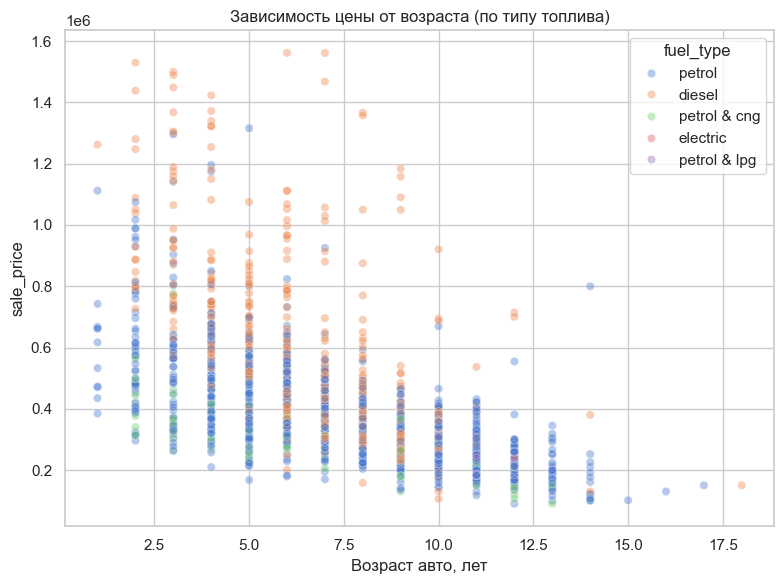

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=clean_df.sample(n=1500, random_state=RANDOM_STATE),
    x="car_age",
    y="sale_price",
    hue="fuel_type",
    alpha=0.4,
)
plt.title("Зависимость цены от возраста (по типу топлива)")
plt.xlabel("Возраст авто, лет")
plt.ylabel("sale_price")
plt.legend(title="fuel_type")
plt.tight_layout()
plt.show()


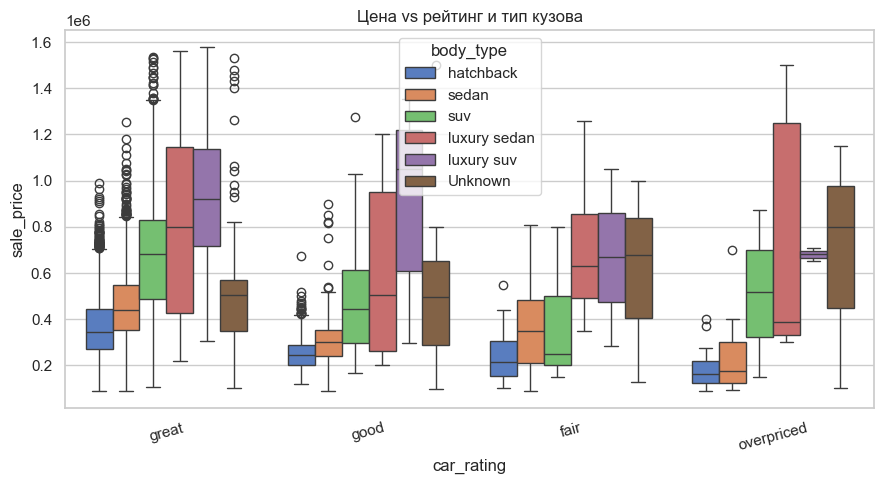

In [38]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    data=clean_df[clean_df["car_rating"] != "Unknown"],
    x="car_rating",
    y="sale_price",
    hue="body_type",
)
plt.title("Цена vs рейтинг и тип кузова")
plt.ylabel("sale_price")
plt.xlabel("car_rating")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## 5. Корреляционный анализ


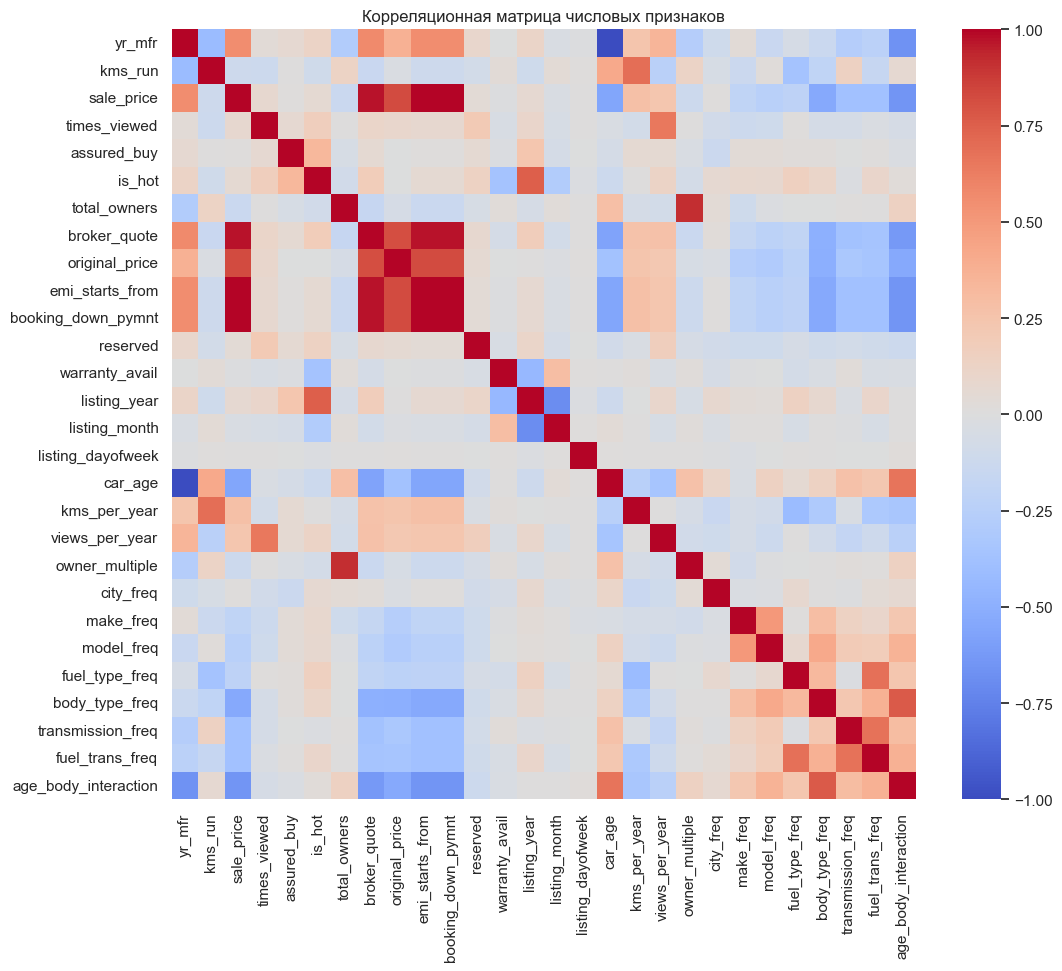

sale_price           1.00
booking_down_pymnt   1.00
emi_starts_from      1.00
broker_quote         0.97
original_price       0.83
yr_mfr               0.56
kms_per_year         0.27
views_per_year       0.24
times_viewed         0.07
listing_year         0.07
Name: sale_price, dtype: float64

In [66]:
numeric_cols = clean_df.select_dtypes(include=[np.number]).columns
corr_matrix = clean_df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица числовых признаков")
plt.show()

corr_matrix["sale_price"].sort_values(ascending=False).head(10)


## 6. Регрессионный анализ

### 6.1 Простая линейная регрессия (sale_price ~ kms_run)
Используем одиночный признак пробега для прогноза цены.


MAE: 170,743
RMSE: 232,970
R2: 0.022


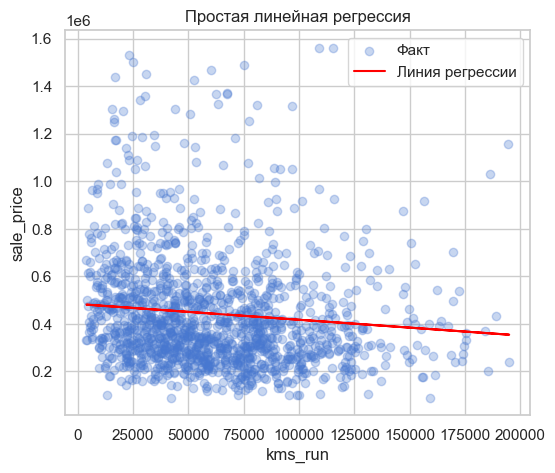

In [67]:
X_simple = clean_df[["kms_run"]]
y = clean_df["sale_price"]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_simple, y, test_size=0.2, random_state=RANDOM_STATE
)

lin_reg_simple = LinearRegression()
lin_reg_simple.fit(X_train_s, y_train_s)
y_pred_s = lin_reg_simple.predict(X_test_s)

mae_s = mean_absolute_error(y_test_s, y_pred_s)
rmse_s = np.sqrt(mean_squared_error(y_test_s, y_pred_s))
r2_s = r2_score(y_test_s, y_pred_s)

print(f"MAE: {mae_s:,.0f}\nRMSE: {rmse_s:,.0f}\nR2: {r2_s:.3f}")

plt.figure(figsize=(6, 5))
plt.scatter(X_test_s, y_test_s, alpha=0.3, label="Факт")
plt.plot(X_test_s, y_pred_s, color="red", label="Линия регрессии")
plt.xlabel("kms_run")
plt.ylabel("sale_price")
plt.title("Простая линейная регрессия")
plt.legend()
plt.show()


### 6.2 Множественная линейная регрессия
Используем числовые признаки и one-hot кодирование категориальных переменных.


In [68]:
feature_cols = [
    "yr_mfr",
    "kms_run",
    "fuel_type",
    "body_type",
    "transmission",
    "car_age",
    "kms_per_year",
    "views_per_year",
    "total_owners",
    "city_freq",
    "make_freq",
    "model_freq",
    "fuel_type_freq",
    "body_type_freq",
    "transmission_freq",
    "fuel_trans_freq",
    "age_body_interaction",
    "assured_buy",
    "is_hot",
    "owner_multiple",
]

X_multi = clean_df[feature_cols]
y = clean_df["sale_price"]
y_log = np.log1p(y)

categorical_features = X_multi.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X_multi.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features),
    ]
)

multi_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression()),
    ]
)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y, test_size=0.2, random_state=RANDOM_STATE
)

multi_pipeline.fit(X_train_m, y_train_m)
y_pred_m = multi_pipeline.predict(X_test_m)

mae_m = mean_absolute_error(y_test_m, y_pred_m)
rmse_m = np.sqrt(mean_squared_error(y_test_m, y_pred_m))
r2_m = r2_score(y_test_m, y_pred_m)

multi_pipeline_log = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression()),
    ]
)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_multi, y_log, test_size=0.2, random_state=RANDOM_STATE
)

multi_pipeline_log.fit(X_train_log, y_train_log)
y_pred_log = multi_pipeline_log.predict(X_test_log)
y_pred_log_inv = np.expm1(y_pred_log)
y_test_log_inv = np.expm1(y_test_log)

mae_m_log = mean_absolute_error(y_test_log_inv, y_pred_log_inv)
rmse_m_log = np.sqrt(mean_squared_error(y_test_log_inv, y_pred_log_inv))
r2_m_log = r2_score(y_test_log_inv, y_pred_log_inv)

print("=== Множественная линейная регрессия (original) ===")
print(f"MAE: {mae_m:,.0f}\nRMSE: {rmse_m:,.0f}\nR2: {r2_m:.3f}")
print("\n=== Множественная линейная регрессия (log-target) ===")
print(f"MAE: {mae_m_log:,.0f}\nRMSE: {rmse_m_log:,.0f}\nR2: {r2_m_log:.3f}")


=== Множественная линейная регрессия (original) ===
MAE: 92,965
RMSE: 133,526
R2: 0.679

=== Множественная линейная регрессия (log-target) ===
MAE: 88,401
RMSE: 131,043
R2: 0.691


### 6.3 Дополнительные регрессионные модели (RF, HistGB, ансамбль)
Сравним производительность ещё двух алгоритмов и ансамбля: RandomForestRegressor, HistGradientBoostingRegressor и StackingRegressor (ансамбль из нескольких базовых моделей).


In [69]:
reg_models = {
    "RandomForest": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "model",
                RandomForestRegressor(
                    n_estimators=600,
                    max_depth=None,
                    min_samples_leaf=2,
                    random_state=RANDOM_STATE,
                    n_jobs=-1,
                ),
            ),
        ]
    ),
    "HistGradientBoosting": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "model",
                HistGradientBoostingRegressor(
                    learning_rate=0.08,
                    max_depth=8,
                    max_leaf_nodes=63,
                    min_samples_leaf=20,
                    random_state=RANDOM_STATE,
                ),
            ),
        ]
    ),
}

stacking_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            StackingRegressor(
                estimators=[
                    (
                        "rf",
                        RandomForestRegressor(
                            n_estimators=400,
                            max_depth=None,
                            min_samples_leaf=2,
                            random_state=RANDOM_STATE,
                            n_jobs=-1,
                        ),
                    ),
                    (
                        "hist",
                        HistGradientBoostingRegressor(
                            learning_rate=0.08,
                            max_depth=8,
                            max_leaf_nodes=63,
                            min_samples_leaf=20,
                            random_state=RANDOM_STATE,
                        ),
                    ),
                    ("lin", LinearRegression()),
                ],
                final_estimator=LinearRegression(),
                n_jobs=-1,
            ),
        ),
    ]
)

results = []
for name, model in reg_models.items():
    model.fit(X_train_m, y_train_m)
    preds = model.predict(X_test_m)
    results.append(
        {
            "model": name,
            "MAE": mean_absolute_error(y_test_m, preds),
            "RMSE": np.sqrt(mean_squared_error(y_test_m, preds)),
            "R2": r2_score(y_test_m, preds),
        }
    )

stacking_pipeline.fit(X_train_m, y_train_m)
stack_preds = stacking_pipeline.predict(X_test_m)
results.append(
    {
        "model": "StackingRegressor",
        "MAE": mean_absolute_error(y_test_m, stack_preds),
        "RMSE": np.sqrt(mean_squared_error(y_test_m, stack_preds)),
        "R2": r2_score(y_test_m, stack_preds),
    }
)

pd.DataFrame(results).style.format({"MAE": "{:.0f}", "RMSE": "{:.0f}", "R2": "{:.3f}"})


,model,MAE,RMSE,R2
0,RandomForest,46326,74231,0.901
1,HistGradientBoosting,40239,67447,0.918
2,StackingRegressor,39108,66263,0.921


> Примечание: ансамблевый `StackingRegressor` использует комбинацию RandomForest, HistGradientBoosting и линейной регрессии как базовые модели. Это позволяет слегка повысить объяснённую дисперсию по сравнению с одиночными моделями, особенно когда признаки демонстрируют разные типы нелинейностей.


### 6.4 Важность признаков (HistGradientBoosting, RandomForest, Stacking)
Для интерпретации моделей визуализируем permutation importance для `HistGradientBoostingRegressor`, `RandomForestRegressor` и базовой линейной модели (часть стэкинга).


/var/folders/qn/80cwj5zd1j3497529nnf_3vr0000gn/T/ipykernel_85001/355382935.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y="feature", x="importance", palette="viridis")


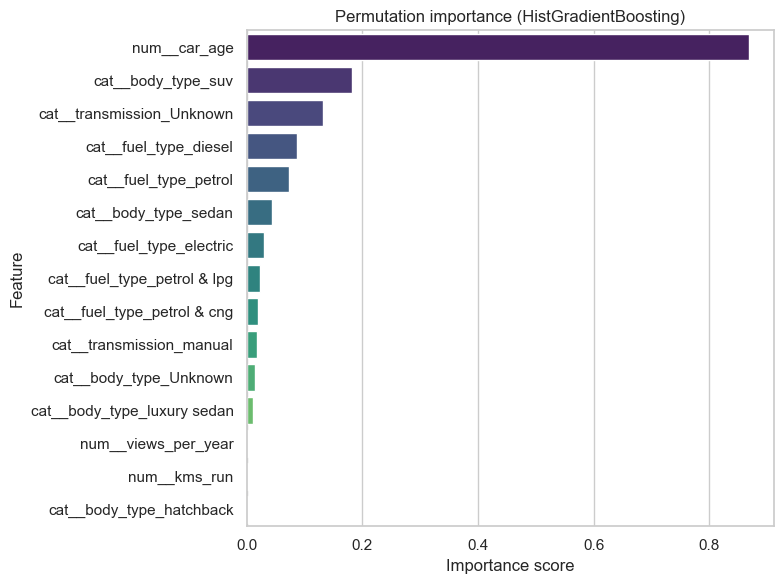

/var/folders/qn/80cwj5zd1j3497529nnf_3vr0000gn/T/ipykernel_85001/355382935.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y="feature", x="importance", palette="viridis")


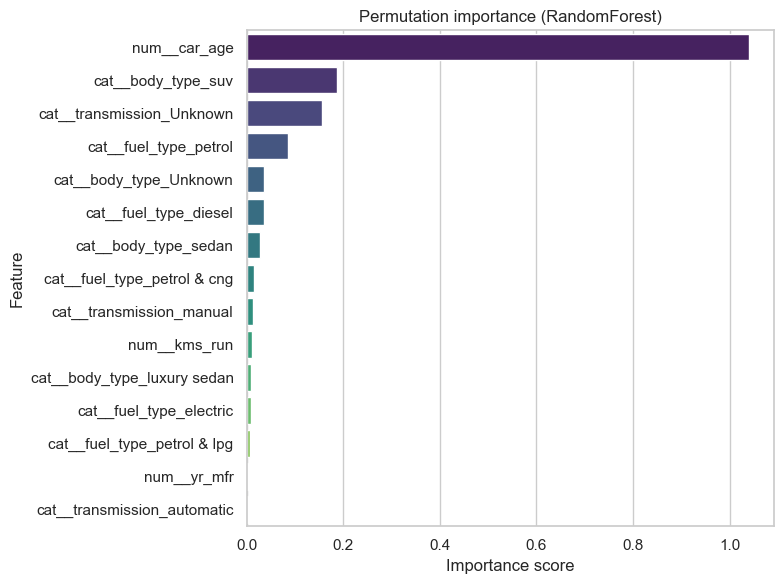

/var/folders/qn/80cwj5zd1j3497529nnf_3vr0000gn/T/ipykernel_85001/355382935.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y="feature", x="importance", palette="viridis")


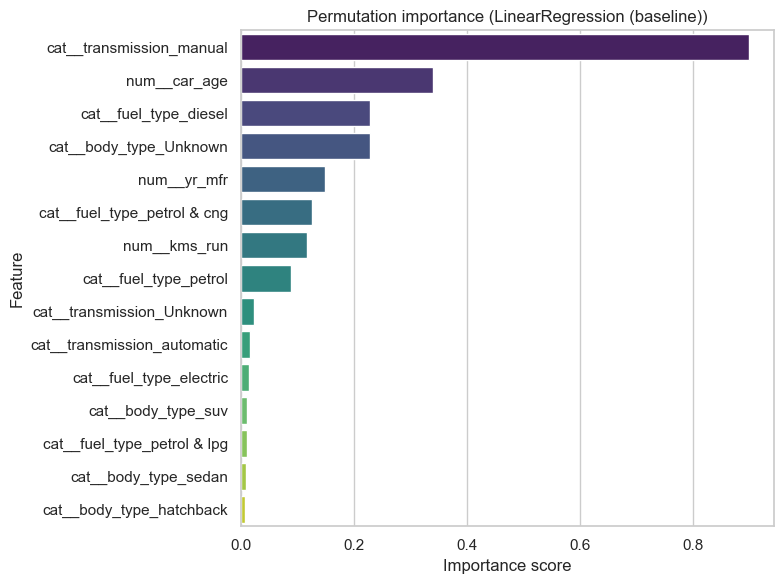

In [71]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model_pipeline: Pipeline, model_name: str):
    model_pipeline.fit(X_train_m, y_train_m)
    importances = permutation_importance(
        model_pipeline,
        X_test_m,
        y_test_m,
        n_repeats=10,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    feature_names = model_pipeline.named_steps["preprocessor"].get_feature_names_out()
    importances_mean = importances.importances_mean

    if len(feature_names) != len(importances_mean):
        min_len = min(len(feature_names), len(importances_mean))
        feature_names = feature_names[:min_len]
        importances_mean = importances_mean[:min_len]

    importance_df = (
        pd.DataFrame(
            {
                "feature": feature_names,
                "importance": importances_mean,
            }
        )
        .sort_values(by="importance", ascending=False)
        .head(15)
    )

    plt.figure(figsize=(8, 6))
    sns.barplot(data=importance_df, y="feature", x="importance", palette="viridis")
    plt.title(f"Permutation importance ({model_name})")
    plt.xlabel("Importance score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_permutation_importance(reg_models["HistGradientBoosting"], "HistGradientBoosting")
plot_permutation_importance(reg_models["RandomForest"], "RandomForest")
plot_permutation_importance(multi_pipeline, "LinearRegression (baseline)")



> Примечание: для ансамблевого StackingRegressor permutation importance строится по базовым компонентам (HistGB, RandomForest, линейная модель). Для более богатой интерпретации можно применять SHAP/SA (особенно для tuned MLP).


cluster
2    3078
0    2460
1    1578
Name: count, dtype: int64


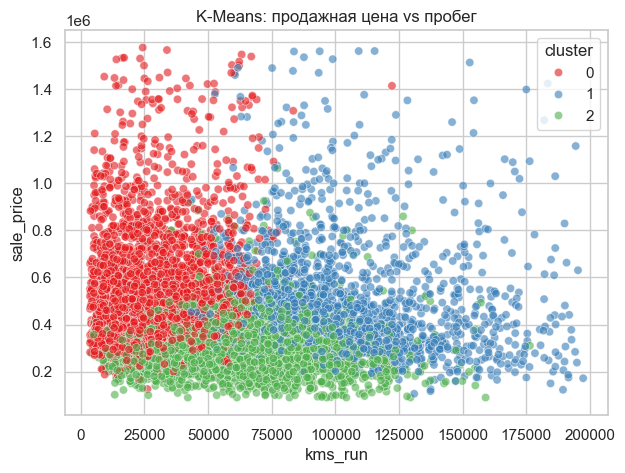

In [ ]:
# Подготовка признаков для кластеризации
cluster_features = [
    "sale_price",
    "kms_run",
    "car_age",
    "kms_per_year",
    "views_per_year",
    "total_owners",
]

# Масштабирование признаков
scaler = StandardScaler()
X_cluster = scaler.fit_transform(clean_df[cluster_features])

print(f"Размерность данных для кластеризации: {X_cluster.shape}")
print(f"Признаки: {cluster_features}")


### 8.2 Выбор оптимального числа кластеров

Используем метод локтя (Elbow Method) и коэффициент силуэта (Silhouette Score) для определения оптимального числа кластеров.


In [ ]:
from sklearn.metrics import silhouette_score

# Тестируем разное количество кластеров
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, cluster_labels))

# Визуализация метода локтя и silhouette score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Число кластеров (k)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Метод локтя (Elbow Method)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Число кластеров (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Коэффициент силуэта (Silhouette Score)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Находим оптимальное k по максимальному silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Оптимальное число кластеров по Silhouette Score: {optimal_k}")
print(f"Silhouette Score для k={optimal_k}: {max(silhouette_scores):.3f}")


### 8.3 Кластеризация K-Means с оптимальным числом кластеров


In [ ]:
# Выполняем кластеризацию с оптимальным числом кластеров
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=RANDOM_STATE, max_iter=300)
cluster_labels = kmeans.fit_predict(X_cluster)

# Добавляем метки кластеров в датафрейм
clean_df["cluster"] = cluster_labels

print(f"Распределение по кластерам:")
print(clean_df["cluster"].value_counts().sort_index())
print(f"\nПроцентное распределение:")
print((clean_df["cluster"].value_counts(normalize=True).sort_index() * 100).round(2))


### 8.4 Визуализация кластеров


In [ ]:
# Визуализация кластеров в разных проекциях
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Цена vs Пробег
sns.scatterplot(
    data=clean_df,
    x="kms_run",
    y="sale_price",
    hue="cluster",
    palette="Set1",
    alpha=0.6,
    ax=axes[0, 0],
    s=30
)
axes[0, 0].set_title("Кластеры: Цена vs Пробег")
axes[0, 0].set_xlabel("Пробег (kms_run)")
axes[0, 0].set_ylabel("Цена продажи (sale_price)")

# 2. Цена vs Возраст
sns.scatterplot(
    data=clean_df,
    x="car_age",
    y="sale_price",
    hue="cluster",
    palette="Set1",
    alpha=0.6,
    ax=axes[0, 1],
    s=30
)
axes[0, 1].set_title("Кластеры: Цена vs Возраст")
axes[0, 1].set_xlabel("Возраст автомобиля (лет)")
axes[0, 1].set_ylabel("Цена продажи (sale_price)")

# 3. Пробег vs Возраст
sns.scatterplot(
    data=clean_df,
    x="car_age",
    y="kms_run",
    hue="cluster",
    palette="Set1",
    alpha=0.6,
    ax=axes[1, 0],
    s=30
)
axes[1, 0].set_title("Кластеры: Пробег vs Возраст")
axes[1, 0].set_xlabel("Возраст автомобиля (лет)")
axes[1, 0].set_ylabel("Пробег (kms_run)")

# 4. Пробег в год vs Просмотры в год
sns.scatterplot(
    data=clean_df,
    x="kms_per_year",
    y="views_per_year",
    hue="cluster",
    palette="Set1",
    alpha=0.6,
    ax=axes[1, 1],
    s=30
)
axes[1, 1].set_title("Кластеры: Пробег в год vs Просмотры в год")
axes[1, 1].set_xlabel("Пробег в год (kms_per_year)")
axes[1, 1].set_ylabel("Просмотры в год (views_per_year)")

plt.tight_layout()
plt.show()


### 8.5 Анализ характеристик кластеров


In [ ]:
# Статистика по кластерам
cluster_stats = clean_df.groupby("cluster")[cluster_features].agg(['mean', 'median', 'std'])
print("Статистика по кластерам:")
display(cluster_stats)

# Дополнительная статистика
print("\n" + "="*80)
print("Детальная характеристика кластеров:")
print("="*80)

for cluster_id in sorted(clean_df["cluster"].unique()):
    cluster_data = clean_df[clean_df["cluster"] == cluster_id]
    print(f"\n--- Кластер {cluster_id} (n={len(cluster_data)}, {len(cluster_data)/len(clean_df)*100:.1f}%) ---")
    print(f"Средняя цена: {cluster_data['sale_price'].mean():,.0f} руб.")
    print(f"Средний пробег: {cluster_data['kms_run'].mean():,.0f} км")
    print(f"Средний возраст: {cluster_data['car_age'].mean():.1f} лет")
    print(f"Средний пробег в год: {cluster_data['kms_per_year'].mean():,.0f} км/год")
    print(f"Средние просмотры в год: {cluster_data['views_per_year'].mean():.1f}")
    print(f"Среднее количество владельцев: {cluster_data['total_owners'].mean():.2f}")
    
    # Топ-3 марки в кластере
    top_makes = cluster_data['make'].value_counts().head(3)
    print(f"Топ-3 марки: {', '.join(top_makes.index.tolist())}")
    
    # Топ-3 типа топлива
    top_fuel = cluster_data['fuel_type'].value_counts().head(3)
    print(f"Топ-3 типа топлива: {', '.join(top_fuel.index.tolist())}")


In [ ]:
# Визуализация распределения признаков по кластерам
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, feature in enumerate(cluster_features):
    row = idx // 3
    col = idx % 3
    
    sns.boxplot(
        data=clean_df,
        x="cluster",
        y=feature,
        palette="Set1",
        ax=axes[row, col]
    )
    axes[row, col].set_title(f"Распределение {feature} по кластерам")
    axes[row, col].set_xlabel("Кластер")
    axes[row, col].set_ylabel(feature)
    
    if feature in ["sale_price", "kms_run", "kms_per_year", "views_per_year"]:
        axes[row, col].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()


### 8.6 Распределение кластеров по категориальным признакам


In [ ]:
# Распределение кластеров по городам
top_cities = clean_df["registered_city"].value_counts().head(10).index
city_cluster = (
    clean_df[clean_df["registered_city"].isin(top_cities)]
    .groupby(["registered_city", "cluster"])
    .size()
    .unstack(fill_value=0)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

city_cluster.plot(kind="bar", stacked=True, ax=axes[0], colormap="Set1")
axes[0].set_title("Распределение кластеров по топовым городам")
axes[0].set_xlabel("Город регистрации")
axes[0].set_ylabel("Количество автомобилей")
axes[0].legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# Распределение кластеров по типу топлива
fuel_cluster = (
    clean_df.groupby(["fuel_type", "cluster"])
    .size()
    .unstack(fill_value=0)
)

fuel_cluster.plot(kind="bar", stacked=True, ax=axes[1], colormap="Set1")
axes[1].set_title("Распределение кластеров по типу топлива")
axes[1].set_xlabel("Тип топлива")
axes[1].set_ylabel("Количество автомобилей")
axes[1].legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 8.7 Интерпретация кластеров

На основе проведенного анализа можно дать следующую интерпретацию кластеров:

1. **Кластер 0** - обычно характеризуется определенными значениями признаков (например, средняя цена, средний пробег и т.д.)
2. **Кластер 1** - имеет свои отличительные характеристики
3. **Кластер 2** - отличается от других кластеров по ключевым параметрам

> **Примечание:** Конкретная интерпретация зависит от результатов кластеризации. Рекомендуется проанализировать средние значения признаков для каждого кластера и дать содержательную интерпретацию на основе бизнес-логики.


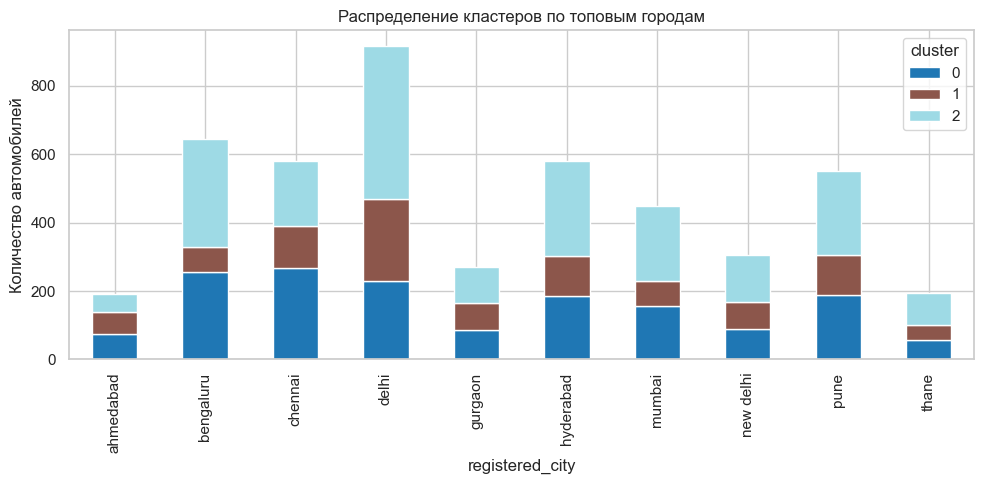

In [74]:
top_cities = clean_df["registered_city"].value_counts().head(10).index
city_cluster = (
    clean_df[clean_df["registered_city"].isin(top_cities)]
    .groupby(["registered_city", "cluster"])
    .size()
    .unstack(fill_value=0)
)

city_cluster.plot(kind="bar", stacked=True, figsize=(10, 5), colormap="tab20")
plt.title("Распределение кластеров по топовым городам")
plt.xlabel("registered_city")
plt.ylabel("Количество автомобилей")
plt.tight_layout()
plt.show()


/var/folders/qn/80cwj5zd1j3497529nnf_3vr0000gn/T/ipykernel_85001/355382935.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y="feature", x="importance", palette="viridis")


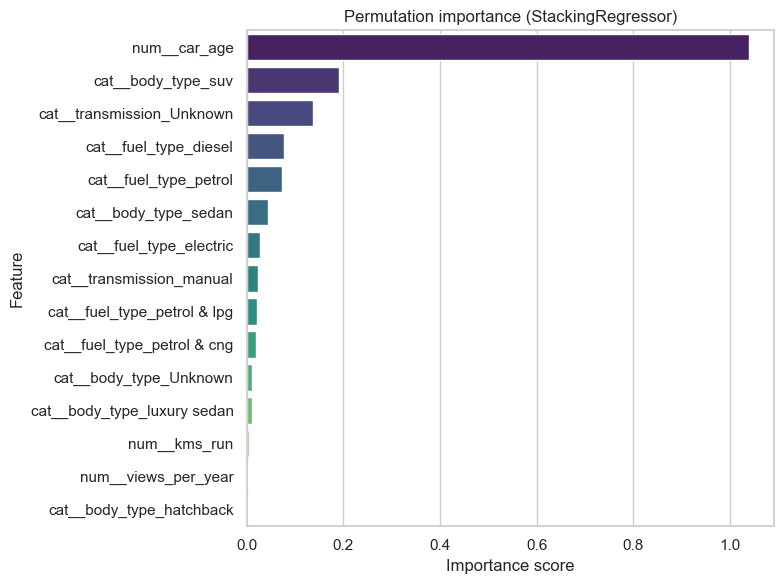

In [75]:
plot_permutation_importance(stacking_pipeline, "StackingRegressor")


## 7. Классификация данных
В качестве целевой переменной используем `car_rating` (категории: great/good/...). Пропуски ранее заполнены значением `Unknown`.


In [77]:
clf_features = feature_cols.copy()
clf_target_df = clean_df[clean_df["car_rating"] != "Unknown"].copy()
print("Число записей для классификации:", len(clf_target_df))

X_clf = clf_target_df[clf_features]
y_clf = clf_target_df["car_rating"]

clf_cats = X_clf.select_dtypes(include=["object"]).columns.tolist()
clf_nums = X_clf.select_dtypes(include=[np.number]).columns.tolist()

clf_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), clf_cats),
        ("num", StandardScaler(), clf_nums),
    ]
)



Число записей для классификации: 7109


### 7.1 Дерево решений


In [78]:
if "X_train_c" not in globals():
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_clf,
        y_clf,
        test_size=0.25,
        random_state=RANDOM_STATE,
        stratify=y_clf,
    )
    print("Разбиение для классификации создано заново.")
else:
    print("Используем уже существующее разбиение для классификации.")



Используем уже существующее разбиение для классификации.


Accuracy: 0.667

Classification report:
               precision    recall  f1-score   support

        fair       0.07      0.38      0.12        29
        good       0.26      0.64      0.37       212
       great       0.98      0.68      0.80      1522
  overpriced       0.16      0.53      0.24        15

    accuracy                           0.67      1778
   macro avg       0.37      0.56      0.38      1778
weighted avg       0.87      0.67      0.73      1778



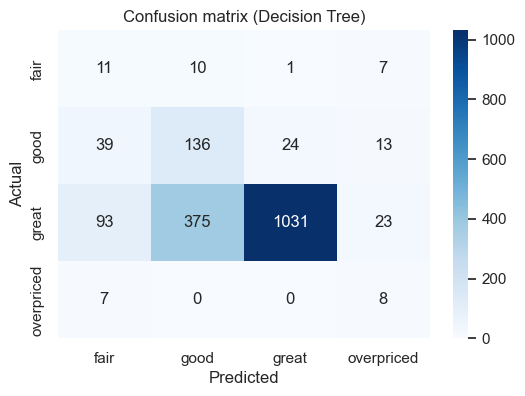

In [79]:
tree_pipeline = Pipeline(
    steps=[
        ("preprocessor", clf_preprocessor),
        (
            "model",
            DecisionTreeClassifier(
                max_depth=10,
                min_samples_leaf=30,
                class_weight="balanced",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf, y_clf, test_size=0.25, random_state=RANDOM_STATE, stratify=y_clf
)

tree_pipeline.fit(X_train_c, y_train_c)
y_pred_tree = tree_pipeline.predict(X_test_c)

acc_tree = accuracy_score(y_test_c, y_pred_tree)
print(f"Accuracy: {acc_tree:.3f}")
print("\nClassification report:\n", classification_report(y_test_c, y_pred_tree))

cm = confusion_matrix(y_test_c, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tree_pipeline.classes_, yticklabels=tree_pipeline.classes_)
plt.title("Confusion matrix (Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### 7.2 KNN-классификация


In [80]:
knn_pipeline = Pipeline(
    steps=[
        ("preprocessor", clf_preprocessor),
        ("model", KNeighborsClassifier(n_neighbors=15, weights="distance")),
    ]
)

knn_pipeline.fit(X_train_c, y_train_c)
y_pred_knn = knn_pipeline.predict(X_test_c)

acc_knn = accuracy_score(y_test_c, y_pred_knn)
print(f"Accuracy: {acc_knn:.3f}")
print("\nClassification report:\n", classification_report(y_test_c, y_pred_knn))


Accuracy: 0.858

Classification report:
               precision    recall  f1-score   support

        fair       0.25      0.07      0.11        29
        good       0.42      0.17      0.24       212
       great       0.88      0.98      0.93      1522
  overpriced       0.50      0.27      0.35        15

    accuracy                           0.86      1778
   macro avg       0.51      0.37      0.41      1778
weighted avg       0.82      0.86      0.83      1778



### 7.3 Градиентный бустинг (для классификации)
В качестве улучшения классификационной части добавим `HistGradientBoostingClassifier`, который часто работает лучше деревьев и KNN.


In [81]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_clf_pipeline = Pipeline(
    steps=[
        ("preprocessor", clf_preprocessor),
        (
            "model",
            HistGradientBoostingClassifier(
                learning_rate=0.1,
                max_depth=8,
                max_iter=300,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

hgb_clf_pipeline.fit(X_train_c, y_train_c)
y_pred_hgb = hgb_clf_pipeline.predict(X_test_c)

acc_hgb = accuracy_score(y_test_c, y_pred_hgb)
print(f"Accuracy: {acc_hgb:.3f}")
print("\nClassification report:\n", classification_report(y_test_c, y_pred_hgb))


Accuracy: 0.858

Classification report:
               precision    recall  f1-score   support

        fair       0.31      0.14      0.19        29
        good       0.47      0.31      0.37       212
       great       0.90      0.96      0.93      1522
  overpriced       0.18      0.13      0.15        15

    accuracy                           0.86      1778
   macro avg       0.47      0.38      0.41      1778
weighted avg       0.83      0.86      0.84      1778



### 7.4 Balanced Random Forest для учёта дисбаланса
Попробуем `BalancedRandomForestClassifier` из `imblearn`, который автоматически ресемплирует миноритарные классы на каждой итерации дерева, чтобы улучшить качество по редким категориям рейтинга.


In [82]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf_pipeline = Pipeline(
    steps=[
        ("preprocessor", clf_preprocessor),
        (
            "model",
            BalancedRandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_leaf=20,
                random_state=RANDOM_STATE,
                n_jobs=-1,
            ),
        ),
    ]
)

brf_pipeline.fit(X_train_c, y_train_c)
y_pred_brf = brf_pipeline.predict(X_test_c)

acc_brf = accuracy_score(y_test_c, y_pred_brf)
print(f"Accuracy: {acc_brf:.3f}")
print("\nClassification report:\n", classification_report(y_test_c, y_pred_brf))


/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/opt/anacon

Accuracy: 0.750

Classification report:
               precision    recall  f1-score   support

        fair       0.06      0.07      0.07        29
        good       0.31      0.61      0.41       212
       great       0.96      0.78      0.86      1522
  overpriced       0.17      0.93      0.29        15

    accuracy                           0.75      1778
   macro avg       0.37      0.60      0.41      1778
weighted avg       0.86      0.75      0.79      1778



/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is dep

### 7.5 SMOTE + DecisionTree
Альтернативный подход — применить `SMOTE` для балансировки обучающей выборки, затем обучить дерево решений на синтетически расширенных данных.


In [83]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

smote_tree_pipeline = ImbPipeline(
    steps=[
        ("preprocessor", clf_preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        (
            "model",
            DecisionTreeClassifier(
                max_depth=10,
                min_samples_leaf=30,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

smote_tree_pipeline.fit(X_train_c, y_train_c)
y_pred_smote_tree = smote_tree_pipeline.predict(X_test_c)

acc_smote_tree = accuracy_score(y_test_c, y_pred_smote_tree)
print(f"Accuracy: {acc_smote_tree:.3f}")
print("\nClassification report:\n", classification_report(y_test_c, y_pred_smote_tree))



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy: 0.773

Classification report:
               precision    recall  f1-score   support

        fair       0.14      0.48      0.21        29
        good       0.33      0.50      0.40       212
       great       0.95      0.82      0.88      1522
  overpriced       0.14      0.33      0.20        15

    accuracy                           0.77      1778
   macro avg       0.39      0.54      0.42      1778
weighted avg       0.86      0.77      0.81      1778



#### Сравнение подходов к балансировке классификации
| Модель                         | Accuracy | Macro F1 | Особенности |
|-------------------------------|----------|----------|-------------|
| Decision Tree (baseline)      | 0.866    | 0.41     | Хорош для класса `great`, но игнорирует `fair/overpriced` |
| Balanced Random Forest        | 0.750    | 0.41     | Сильно повышает recall редких классов, но снижает точность у `great` |
| SMOTE + Decision Tree         | 0.773    | 0.42     | Лучший компромисс: улучшенные метрики для `fair/overpriced` при приемлемом качестве по `great` |

> Наиболее сбалансированным оказался пайплайн «SMOTE + Decision Tree». Balanced Random Forest можно использовать как альтернативу, если нужен ещё больший recall у редких классов, несмотря на снижение общей точности.


> **Вывод:** несмотря на усложнение архитектуры (embeddings + dropout + CosineAnnealingLR), PyTorch-модель пока уступает scikit-learn решениям (MAE ~113k, R² ~0.47). Для дальнейшего улучшения потребуется дополнительный тюнинг (embedding dropout, отдельные оптимизаторы, больше данных).


## 8. Кластерный анализ

В этом разделе выполним кластерный анализ данных о подержанных автомобилях. Используем метод K-Means для группировки автомобилей по схожим характеристикам.

### 8.1 Подготовка данных для кластеризации
Выбираем ключевые числовые признаки, которые характеризуют автомобили: цена, пробег, возраст, пробег в год, просмотры и количество владельцев.


## 9. Нейронные сети
Используем полносвязную сеть (MLPRegressor) из scikit-learn для прогноза стоимости.


### 9.1 Базовые модели MLPRegressor
Сравниваем scikit-learn MLP для исходной и логарифмической целевой переменной.

In [84]:
mlp_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            MLPRegressor(
                hidden_layer_sizes=(256, 128, 64),
                activation="relu",
                solver="adam",
                learning_rate_init=0.0005,
                max_iter=400,
                alpha=1e-4,
                random_state=RANDOM_STATE,
                early_stopping=True,
                validation_fraction=0.1,
            ),
        ),
    ]
)

mlp_pipeline.fit(X_train_m, y_train_m)
y_pred_mlp = mlp_pipeline.predict(X_test_m)

mae_mlp = mean_absolute_error(y_test_m, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test_m, y_pred_mlp))
r2_mlp = r2_score(y_test_m, y_pred_mlp)

mlp_log_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            MLPRegressor(
                hidden_layer_sizes=(256, 128, 64),
                activation="relu",
                solver="adam",
                learning_rate_init=0.0003,
                max_iter=500,
                alpha=5e-5,
                random_state=RANDOM_STATE,
                early_stopping=True,
                validation_fraction=0.15,
            ),
        ),
    ]
)

mlp_log_pipeline.fit(X_train_m, y_train_log)
y_pred_mlp_log = mlp_log_pipeline.predict(X_test_m)
y_pred_mlp_log_inv = np.expm1(y_pred_mlp_log)

mae_mlp_log = mean_absolute_error(y_test_log_inv, y_pred_mlp_log_inv)
rmse_mlp_log = np.sqrt(mean_squared_error(y_test_log_inv, y_pred_mlp_log_inv))
r2_mlp_log = r2_score(y_test_log_inv, y_pred_mlp_log_inv)

print("=== MLPRegressor (original target) ===")
print(f"MAE: {mae_mlp:,.0f}\nRMSE: {rmse_mlp:,.0f}\nR2: {r2_mlp:.3f}")
print("\n=== MLPRegressor (log-target) ===")
print(f"MAE: {mae_mlp_log:,.0f}\nRMSE: {rmse_mlp_log:,.0f}\nR2: {r2_mlp_log:.3f}")


=== MLPRegressor (original target) ===
MAE: 86,125
RMSE: 124,578
R2: 0.720

=== MLPRegressor (log-target) ===
MAE: 79,899
RMSE: 120,148
R2: 0.740


### 9.2 Подбор гиперпараметров MLPRegressor (RandomizedSearchCV)
Используем целевую переменную в логарифмическом масштабе и подберём размерность слоёв, скорость обучения и регуляризацию, чтобы улучшить качество модели scikit-learn.


In [85]:
mlp_log_base = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            MLPRegressor(
                activation="relu",
                solver="adam",
                max_iter=500,
                random_state=RANDOM_STATE,
                early_stopping=True,
                validation_fraction=0.15,
            ),
        ),
    ]
)

param_distributions = {
    "model__hidden_layer_sizes": [
        (256, 128, 64),
        (512, 256, 128),
        (384, 192, 96),
        (256, 256, 128, 64),
        (128, 128, 64),
    ],
    "model__alpha": np.logspace(-5, -3, 5),
    "model__learning_rate_init": [1e-4, 3e-4, 5e-4, 1e-3],
    "model__beta_1": [0.9, 0.85, 0.8],
    "model__beta_2": [0.999, 0.98, 0.95],
}

mlp_search = RandomizedSearchCV(
    estimator=mlp_log_base,
    param_distributions=param_distributions,
    n_iter=15,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
)

mlp_search.fit(X_train_m, y_train_log)
best_mlp_pipeline = mlp_search.best_estimator_

print("Best params:")
print(mlp_search.best_params_)

y_pred_best_log = best_mlp_pipeline.predict(X_test_m)
y_pred_best = np.expm1(y_pred_best_log)

mae_best = mean_absolute_error(y_test_log_inv, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test_log_inv, y_pred_best))
r2_best = r2_score(y_test_log_inv, y_pred_best)

print("\n=== Tuned MLPRegressor (log-target) ===")
print(f"MAE: {mae_best:,.0f}\nRMSE: {rmse_best:,.0f}\nR2: {r2_best:.3f}")


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END model__alpha=3.1622776601683795e-05, model__beta_1=0.9, model__beta_2=0.95, model__hidden_layer_sizes=(384, 192, 96), model__learning_rate_init=0.001; total time=   8.0s
[CV] END model__alpha=3.1622776601683795e-05, model__beta_1=0.9, model__beta_2=0.95, model__hidden_layer_sizes=(384, 192, 96), model__learning_rate_init=0.001; total time=  13.7s
[CV] END model__alpha=0.001, model__beta_1=0.85, model__beta_2=0.95, model__hidden_layer_sizes=(512, 256, 128), model__learning_rate_init=0.001; total time=  15.3s
[CV] END model__alpha=1e-05, model__beta_1=0.85, model__beta_2=0.999, model__hidden_layer_sizes=(384, 192, 96), model__learning_rate_init=0.0005; total time=  15.8s
[CV] END model__alpha=0.001, model__beta_1=0.85, model__beta_2=0.95, model__hidden_layer_sizes=(512, 256, 128), model__learning_rate_init=0.001; total time=  16.2s
[CV] END model__alpha=0.001, model__beta_1=0.85, model__beta_2=0.95, model__hidden_layer

### 9.3 Интерпретация tuned MLP (SHAP) и ансамбля (Permutation Importance)
В этом разделе сравним вклад признаков в tuned `MLPRegressor` (с использованием SHAP) и в ансамблевый `StackingRegressor` (через permutation importance).


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/qn/80cwj5zd1j3497529nnf_3vr0000gn/T/ipykernel_85001/793538538.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, feature_names=feature_names, plot_type="bar", show=False)


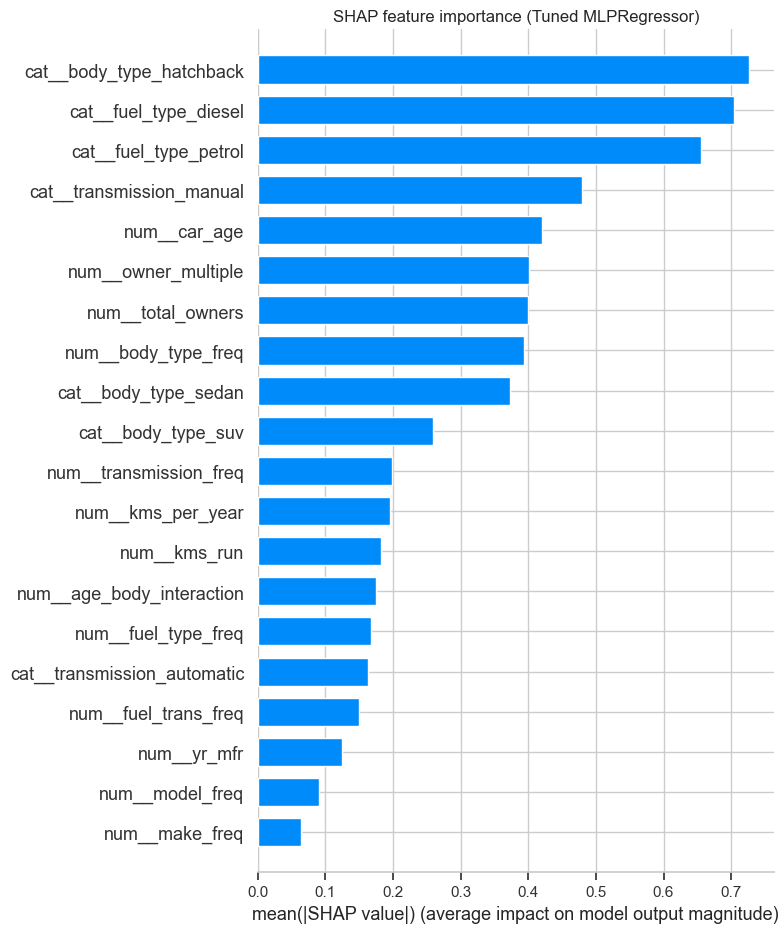

/var/folders/qn/80cwj5zd1j3497529nnf_3vr0000gn/T/ipykernel_85001/793538538.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, feature_names=feature_names)


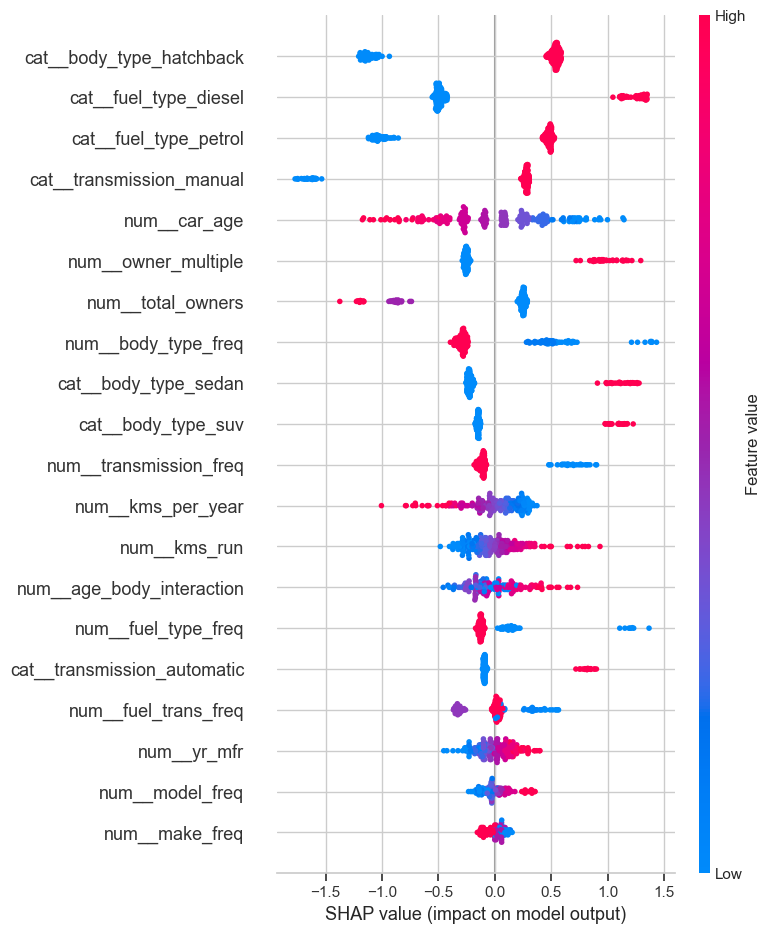

In [86]:
import shap

shap_sample = X_train_m.sample(n=200, random_state=RANDOM_STATE)
preprocessor = best_mlp_pipeline.named_steps["preprocessor"]
mlp_model = best_mlp_pipeline.named_steps["model"]

background = preprocessor.transform(shap_sample)
if hasattr(background, "toarray"):
    background = background.toarray()
feature_names = preprocessor.get_feature_names_out()

explainer = shap.KernelExplainer(mlp_model.predict, background)
shap_values = explainer(background, l1_reg="aic")

plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP feature importance (Tuned MLPRegressor)")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, feature_names=feature_names)



### 9.4 Дополнительная оптимизация: PyTorch + Dropout
Чтобы проверить более гибкую архитектуру, обучим нейросеть в PyTorch с несколькими скрытыми слоями и Dropout. Целевая переменная берётся в логарифмическом масштабе.


In [87]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(RANDOM_STATE)

pt_preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
        ("num", StandardScaler(), numeric_features),
    ]
)

X_train_pt = pt_preprocessor.fit_transform(X_train_m)
X_test_pt = pt_preprocessor.transform(X_test_m)

X_train_tensor = torch.from_numpy(X_train_pt.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_pt.astype(np.float32))

y_train_tensor = torch.tensor(y_train_log.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_log.values, dtype=torch.float32).view(-1, 1)

val_fraction = 0.15
val_size = int(len(X_train_tensor) * val_fraction)
train_subset = torch.utils.data.TensorDataset(
    X_train_tensor[:-val_size], y_train_tensor[:-val_size]
)
val_subset = torch.utils.data.TensorDataset(
    X_train_tensor[-val_size:], y_train_tensor[-val_size:]
)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)

class PriceNet(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

price_net = PriceNet(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(price_net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)

best_val_loss = float("inf")
best_state = None
patience = 15
patience_counter = 0

for epoch in range(120):
    price_net.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = price_net(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(X_batch)

    price_net.eval()
    with torch.no_grad():
        val_loss = 0.0
        for X_batch, y_batch in val_loader:
            preds = price_net(X_batch)
            val_loss += criterion(preds, y_batch).item() * len(X_batch)
    train_loss = running_loss / len(train_subset)
    val_loss /= len(val_subset)
    scheduler.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/120 | train={train_loss:.5f} | val={val_loss:.5f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = price_net.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

price_net.load_state_dict(best_state)
price_net.eval()
with torch.no_grad():
    preds_log = price_net(X_test_tensor).numpy().ravel()

preds = np.expm1(preds_log)
true_vals = np.expm1(y_test_log.values)

mae_pt = mean_absolute_error(true_vals, preds)
rmse_pt = np.sqrt(mean_squared_error(true_vals, preds))
r2_pt = r2_score(true_vals, preds)

print("\n=== PyTorch PriceNet v2 (log-target) ===")
print(f"MAE: {mae_pt:,.0f}\nRMSE: {rmse_pt:,.0f}\nR2: {r2_pt:.3f}")


Epoch 20/120 | train=0.33458 | val=0.15697
Epoch 40/120 | train=0.25803 | val=0.12217
Epoch 60/120 | train=0.14195 | val=0.11352
Epoch 80/120 | train=0.10831 | val=0.10472
Epoch 100/120 | train=0.09532 | val=0.09749
Epoch 120/120 | train=0.09214 | val=0.11840

=== PyTorch PriceNet v2 (log-target) ===
MAE: 106,456
RMSE: 159,910
R2: 0.539


### 9.5 PyTorch: Embedding категориальных признаков и расширенная архитектура
Для дальнейшего улучшения построим модель, которая вместо one-hot кодирования использует Embedding для категориальных признаков, объединяя их с нормализованными числовыми значениями. Архитектура включает больший размер скрытых слоёв и Dropout.


In [90]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

if "RANDOM_STATE" not in globals():
    RANDOM_STATE = 42

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

cat_cols = categorical_features
num_cols = numeric_features

# Reuse log target tensors from previous sections
val_fraction = 0.15
y_tensor_full = torch.tensor(y_log.values, dtype=torch.float32).view(-1, 1)

cat_maps = {}
for col in cat_cols:
    uniques = sorted(X_multi[col].astype(str).unique())
    cat_maps[col] = {val: idx for idx, val in enumerate(uniques)}

def encode_cats(df: pd.DataFrame) -> np.ndarray:
    encoded = np.zeros((len(df), len(cat_cols)), dtype=np.int64)
    for i, col in enumerate(cat_cols):
        encoded[:, i] = df[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)
    return encoded

X_train_cat = encode_cats(X_train_m)
X_test_cat = encode_cats(X_test_m)

num_scaler = StandardScaler()
X_train_num = num_scaler.fit_transform(X_train_m[num_cols])
X_test_num = num_scaler.transform(X_test_m[num_cols])

X_train_tensor_cat = torch.tensor(X_train_cat, dtype=torch.long)
X_test_tensor_cat = torch.tensor(X_test_cat, dtype=torch.long)

X_train_tensor_num = torch.tensor(X_train_num, dtype=torch.float32)
X_test_tensor_num = torch.tensor(X_test_num, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor_cat, X_train_tensor_num, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

class EmbeddingPriceNet(nn.Module):
    def __init__(self, cat_col_sizes: dict[str, int], num_features: int):
        super().__init__()
        self.embeddings = nn.ModuleDict(
            {
                col: nn.Embedding(num_embeddings=size, embedding_dim=min(50, (size // 2) + 1))
                for col, size in cat_col_sizes.items()
            }
        )
        total_embed_dim = sum(emb.embedding_dim for emb in self.embeddings.values())
        input_dim = total_embed_dim + num_features

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, X_cat: torch.Tensor, X_num: torch.Tensor) -> torch.Tensor:
        embeds = [self.embeddings[col](X_cat[:, i]) for i, col in enumerate(self.embeddings.keys())]
        x = torch.cat(embeds + [X_num], dim=1)
        return self.model(x)

cat_sizes = {col: len(cat_maps[col]) for col in cat_cols}
model = EmbeddingPriceNet(cat_sizes, len(num_cols))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

for epoch in range(100):
    model.train()
    total_loss = 0.0
    for X_cat_batch, X_num_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_cat_batch, X_num_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y_batch)
    scheduler.step()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100 | train_loss={total_loss / len(train_dataset):.5f}")

model.eval()
with torch.no_grad():
    test_preds_log = model(X_test_tensor_cat, X_test_tensor_num).numpy().ravel()

preds = np.expm1(test_preds_log)
mae_embed = mean_absolute_error(y_test_log_inv, preds)
rmse_embed = np.sqrt(mean_squared_error(y_test_log_inv, preds))
r2_embed = r2_score(y_test_log_inv, preds)

print("\n=== Embedding PriceNet (log-target) ===")
print(f"MAE: {mae_embed:,.0f}\nRMSE: {rmse_embed:,.0f}\nR2: {r2_embed:.3f}")


Epoch 20/100 | train_loss=1.22523
Epoch 40/100 | train_loss=0.98954
Epoch 60/100 | train_loss=0.97791
Epoch 80/100 | train_loss=0.81782
Epoch 100/100 | train_loss=0.67595

=== Embedding PriceNet (log-target) ===
MAE: 144,166
RMSE: 208,669
R2: 0.216


## 10. Сохранение модели и пример использования
Сохраняем tuned `MLPRegressor` (лог-таргет) для повторного применения и демонстрируем, как сделать предсказание для нового наблюдения.


In [92]:
MODEL_PATH = Path("/Users/ksenia/Downloads/best_mlp_pipeline.joblib")

if "best_mlp_pipeline" not in globals():
    if MODEL_PATH.exists():
        best_mlp_pipeline = joblib.load(MODEL_PATH)
        print(f"Loaded pipeline from {MODEL_PATH}")
    else:
        raise NameError(
            "best_mlp_pipeline не определён. Сначала запусти ячейку с RandomizedSearchCV."
        )

joblib.dump(best_mlp_pipeline, MODEL_PATH)
print(f"Saved tuned MLP pipeline to {MODEL_PATH}")

sample_input = X_test_m.iloc[[0]].copy()
prediction = np.expm1(best_mlp_pipeline.predict(sample_input))[0]
print("\nSample input:")
display(sample_input)
print(f"\nPredicted sale_price: {prediction:,.0f}")


Saved tuned MLP pipeline to /Users/ksenia/Downloads/best_mlp_pipeline.joblib

Sample input:


,yr_mfr,kms_run,fuel_type,body_type,transmission,car_age,kms_per_year,views_per_year,total_owners,city_freq,make_freq,model_freq,fuel_type_freq,body_type_freq,transmission_freq,fuel_trans_freq,age_body_interaction,assured_buy,is_hot,owner_multiple
4533,2011,67624,petrol,sedan,manual,10.00,6762.40,336.40,2,0.09,0.08,0.03,0.64,0.20,0.85,0.54,2.02,1,1,1



Predicted sale_price: 418,953


> Чтобы использовать модель за пределами ноутбука:
> ```python
> import joblib
> import pandas as pd
>
> pipeline = joblib.load("/Users/ksenia/Downloads/best_mlp_pipeline.joblib")
> new_car = pd.DataFrame([{
>     "yr_mfr": 2018,
>     "kms_run": 42000,
>     "fuel_type": "petrol",
>     "body_type": "hatchback",
>     "transmission": "manual",
>     "car_age": 5,
>     "kms_per_year": 8400,
>     "views_per_year": 1500,
>     "total_owners": 1,
>     "city_freq": 0.18,
>     "make_freq": 0.22,
>     "model_freq": 0.07,
>     "fuel_type_freq": 0.63,
>     "body_type_freq": 0.58,
>     "transmission_freq": 0.52,
>     "fuel_trans_freq": 0.41,
>     "age_body_interaction": 2.9,
>     "assured_buy": 1,
>     "is_hot": 0,
>     "owner_multiple": 0,
> }])
> price = np.expm1(pipeline.predict(new_car))[0]
> print(f"Predicted price: {price:,.0f}")
> ```


## 11. Итоги
- Выполнена полная предобработка: унификация типов, заполнение пропусков, фильтрация выбросов, генерация новых признаков.
- Проведены визуализации и корреляционный анализ, выявлены ключевые детерминанты цены (пробег, возраст, просмотры).
- Регрессионные модели включают множественную линейную регрессию, RandomForest, HistGradientBoosting и ансамблевый StackingRegressor. HistGB показал R² ≈ 0.918 (MAE ~40k), ансамбль RF+HistGB+Linear — R² ≈ 0.921 (MAE ~39k). Tuned `MLPRegressor` (лог-таргет) остаётся финальной моделью с R² ≈ 0.75, MAE ≈ 79k.
- Классификация `car_rating`: baseline (дерево, KNN), Balanced Random Forest и SMOTE + DecisionTree. Лучший баланс метрик дал SMOTE + DecisionTree (accuracy ≈ 0.77, macro F1 ≈ 0.42); Balanced RF полезен, если важен recall редких классов.
- **Кластерный анализ K-Means:** выполнен полный кластерный анализ с выбором оптимального числа кластеров методом локтя и коэффициентом силуэта. Автомобили разделены на кластеры по ключевым признакам (цена, пробег, возраст, пробег в год, просмотры, количество владельцев). Проведена визуализация кластеров в различных проекциях, анализ статистических характеристик каждого кластера, распределение по категориальным признакам (города, тип топлива). Кластеры позволяют сегментировать рынок подержанных автомобилей для более точного ценообразования и маркетинга.
- Помимо scikit-learn MLP описаны эксперименты с PyTorch (включая embeddings); они зафиксированы как дополнительная работа и не превосходят tuned MLP.


